In [1]:
import gymnasium
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
from itertools import count
from torch.distributions import Categorical
from sklearn.preprocessing import StandardScaler

In [28]:
class StockEnvironment(gymnasium.Env):
  def __init__(self, folder_path, num_agents = 2, train = True, number_of_days_to_consider = 40, split_ratio = 0.8):
    super(StockEnvironment, self).__init__()

    self.num_agents = num_agents
    self.folder_path = folder_path
    self.train = train
    self.number_of_days_to_consider = number_of_days_to_consider
    self.split_ratio = split_ratio

    self.data = self.load_data(folder_path)
    #print(f"Total Rows: {len(self.data)}")
    #print(f"Total Columns: {len(self.data.columns)}")
    #print("Columns:", self.data.columns.tolist())
    #print("Unique Symbols:", self.data['Symbol'].unique())
    #self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
    #self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

    split_index = int(len(self.data) * self.split_ratio)
    self.training_data = self.data.iloc[:split_index]
    self.testing_data = self.data.iloc[split_index:].reset_index(drop=True)

    self.stock_data = self.training_data if self.train else self.testing_data

    self.action_spaces = {agent_id: spaces.Discrete(3) for agent_id in range(self.num_agents)}
    self.observation_spaces = {agent_id: spaces.Discrete(4) for agent_id in range(self.num_agents)}

    self.agent_states = {agent_id: self.initialize_agent_state() for agent_id in range(self.num_agents)}

    #self.investment_capital = 10000
    #self.number_of_shares = 0
    #self.stock_value = 0
    #self.book_value = 0

    #self.total_account_value = self.investment_capital + self.stock_value
    #self.total_account_value_list = []

    if self.train:
        self.max_timesteps = len(self.training_data) - self.number_of_days_to_consider -1
    else:
        self.max_timesteps = len(self.testing_data) - self.number_of_days_to_consider -1
    self.timestep = 0
    #self.reset()

  def initialize_agent_state(self):
    return {
            "investment_capital": 100000,
            "number_of_shares": 0,
            "stock_value": 0,
            "book_value": 0,
            "total_account_value": 100000,
            "total_account_value_list": [],
        }


  def load_data(self, folder_path):
    combined_data = []
    for filename in os.listdir(folder_path):
      if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        stock_data = pd.read_csv(file_path)
        #stock_data['Symbol'] = filename.replace('_data.csv', '')
        stock_data.columns = ['Date'] + list(stock_data.columns[1:])
        symbol = filename.split('_data.csv')[0]
        stock_data['Symbol'] = symbol
        combined_data.append(stock_data)

    if not combined_data:
          raise ValueError("No data found in the folder.")

    combined_data = pd.concat(combined_data, axis=0)
    #combined_data.sort_values(by=['Symbol', 'Date'], inplace=True)
    combined_data[['open', 'high', 'low', 'close', 'volume']] = StandardScaler().fit_transform(combined_data[['open', 'high', 'low', 'close', 'volume']])
    return combined_data

  def reset(self):

    self.timestep = 0
    self.agent_states = {agent_id: self.initialize_agent_state() for agent_id in range(self.num_agents)}
    #observations = {}
    #for agent_id in range(self.num_agents):
        #observations[agent_id] = self.generate_observation(agent_id)
    observations = {agent_id: self.generate_observation(agent_id) for agent_id in range(self.num_agents)}
    print(f"Reset states: {observations}")
    return observations


  def generate_observation(self, agent_id):

    price_increase_list = []
    stock_data = self.stock_data


    #for i in range(self.number_of_days_to_consider):
     # current_price = stock_data['close'].iloc[self.timestep + i]
    #  next_price = stock_data['close'].iloc[self.timestep + 1 + i]
    #  if next_price - current_price > 0:
    #      price_increase_list.append(1)
    #  else:
    #      price_increase_list.append(0)



    for i in range(self.number_of_days_to_consider):
        current_price = stock_data['close'].iloc[self.timestep + i]
        next_price = stock_data['close'].iloc[self.timestep + 1 + i]
        if next_price - current_price > 0:
            price_increase_list.append(1)
        else:
            price_increase_list.append(0)


    price_increase = (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5
    stock_held = self.agent_states[agent_id]['number_of_shares'] > 0

    if price_increase and not stock_held:
        observation = 0
    elif price_increase and stock_held:
        observation = 1
    elif not price_increase and not stock_held:
        observation = 2
    else:
        observation = 3 #not price_increase and stock_held
    return observation


  def step(self,actions):
    #print(f"Current timestep: {self.timestep}")
    rewards = {}
    observations = {}
    for agent_id, action in actions.items():
      reward = self.environment_action(agent_id, action)
      rewards[agent_id] = reward
      observations[agent_id] = self.generate_observation(agent_id)
      reward = self.environment_action(agent_id, action)
      self.agent_states[agent_id]['total_account_value'] = self.agent_states[agent_id]['investment_capital'] + self.agent_states[agent_id]['stock_value']
      self.agent_states[agent_id]['total_account_value_list'].append(self.agent_states[agent_id]['total_account_value'])
      rewards[agent_id] = reward
      observations[agent_id] = self.generate_observation(agent_id)


    #print(f"Rewards calculated: {rewards}")
    self.timestep += 1
    terminated = self.timestep >= self.max_timesteps
    
    #for agent_id in actions.keys():
        #observations[agent_id] = self.generate_observation(agent_id)

    truncated = False
    info = {}

    return observations, rewards, terminated, truncated, info
  
  def render(self, mode='human'):

    plt.figure(figsize=(15, 10))
    for agent_id, state in self.agent_states.items():
        plt.plot(state['total_account_value_list'], label=f'Agent {agent_id}', linewidth=3)
    plt.xlabel('Days', fontsize=32)
    plt.ylabel('Total Account Value', fontsize=32)
    plt.title('Total Account Value over Time for All Agents', fontsize=38)
    plt.legend(fontsize=18)
    plt.grid(True)
    plt.show()

  def environment_action(self, agent_id, action):
    reward = 0
    agent_state = self.agent_states[agent_id]
    penalty = 0
    transaction_cost = 0

    number_of_shares_to_buy = 0  # Default to 0 if not set by conditions
    current_price_index = self.timestep + self.number_of_days_to_consider
    if current_price_index < len(self.stock_data):
        current_price = self.stock_data['open'].iloc[current_price_index]

        #action logic
        if action == 0:  #buy shares
            if agent_state['number_of_shares'] > 0:
                penalty = -1
            number_of_shares_to_buy = math.floor(agent_state['investment_capital'] / current_price)
            transaction_cost = current_price * number_of_shares_to_buy * 0.005 

            if number_of_shares_to_buy > 0:
                agent_state['number_of_shares'] += number_of_shares_to_buy
                agent_state['stock_value'] = agent_state['number_of_shares'] * current_price
                agent_state['investment_capital'] -= number_of_shares_to_buy * current_price
                agent_state['book_value'] += current_price * number_of_shares_to_buy
                reward = number_of_shares_to_buy * 0.1 - transaction_cost
            else:
                reward = -10
        elif action == 1:  #sell shares
            if agent_state['number_of_shares'] > 0:
                sell_value = current_price * agent_state['number_of_shares']
                transaction_cost = sell_value * 0.005
                profit = sell_value - agent_state['book_value'] - transaction_cost
                reward = profit 
                agent_state['investment_capital'] += sell_value - transaction_cost
                agent_state['number_of_shares'] = 0
                agent_state['stock_value'] = 0
                agent_state['book_value'] = 0
            else:
               reward = -1

        elif action == 2:  #hold shares
            agent_state['stock_value'] = current_price * agent_state['number_of_shares']
            if agent_state['number_of_shares'] > 0 and agent_state['book_value'] > 0:
                unrealized_profit = agent_state['stock_value'] - agent_state['book_value']
                reward = unrealized_profit / agent_state['book_value'] 
            else:
                reward = -0.1
                
        agent_state['stock_value'] = current_price * agent_state['number_of_shares']
        agent_state['total_account_value'] = agent_state['investment_capital'] + agent_state['stock_value']        
    else:
        print(f"Index {current_price_index} out of bounds for stock_data with length {len(self.stock_data)}")
        reward = 0
    return reward



In [29]:
env = StockEnvironment('data/', train =True, number_of_days_to_consider= 40)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
def check_versions(tensor, name):
    print(f"Version of {name}: {tensor._version}")

class Actor(nn.Module):
    def __init__(self, observation, action):
        super(Actor, self).__init__()
        self.embedding = nn.Embedding(observation, 10) 
        self.layer1 = nn.Linear(10, 128)
        self.layer2 = nn.Linear(128, action)

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        #check_versions(x, "after embedding")
        x = x.view(-1, 10)
        #check_versions(x, "after view")
        x = F.relu(self.layer1(x))
        #check_versions(x, "after relu")
        x = self.layer2(x)
        #check_versions(x, "after final layer")
        return F.softmax(x, dim=-1)

In [32]:
class Critic(nn.Module):
    def __init__(self, observation):
        super(Critic, self).__init__()
        self.embedding = nn.Embedding(observation, 10)
        self.layer1 = nn.Linear(10, 128)
        self.layer2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        #print("Critic_Version after embedding:", x._version)
        x = x.view(-1, 10)
        #print("Critic_Version after view:", x._version)
        x = F.relu(self.layer1(x))
        #print("Critic_Version after relu:", x._version)
        x = self.layer2(x)
        #print("Critic_Version after final layer:", x._version)
        return x


In [33]:
env = StockEnvironment('data/', num_agents=2, train=True)
observation = 4
action = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
actor = Actor(observation, action).to(device)
critic = Critic(observation).to(device)
actor_optimizer = optim.Adam(actor.parameters(), lr=0.01)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.01)

num_episodes = 100
gamma = 0.99

Reset states: {0: 2, 1: 2}
Episode 1 completed. Rewards: {0: -33933.65896546493, 1: -32742.16812924639}
Reset states: {0: 2, 1: 2}
Episode 2 completed. Rewards: {0: -32414.218382279396, 1: -33156.819188887304}
Reset states: {0: 2, 1: 2}
Episode 3 completed. Rewards: {0: -33824.9490695833, 1: -33273.29944078078}
Reset states: {0: 2, 1: 2}
Episode 4 completed. Rewards: {0: -32942.59572662803, 1: -33032.54445316706}
Reset states: {0: 2, 1: 2}
Episode 5 completed. Rewards: {0: -32942.76903968932, 1: -33554.69350898336}
Reset states: {0: 2, 1: 2}
Episode 6 completed. Rewards: {0: -33060.09406245483, 1: -32324.28699686489}
Reset states: {0: 2, 1: 2}
Episode 7 completed. Rewards: {0: -33184.10635375394, 1: -33589.358834088875}
Reset states: {0: 2, 1: 2}
Episode 8 completed. Rewards: {0: -32335.203059467185, 1: -32929.92008590866}
Reset states: {0: 2, 1: 2}
Episode 9 completed. Rewards: {0: -33345.95021933112, 1: -33792.56693088349}
Reset states: {0: 2, 1: 2}
Episode 10 completed. Rewards: {0:

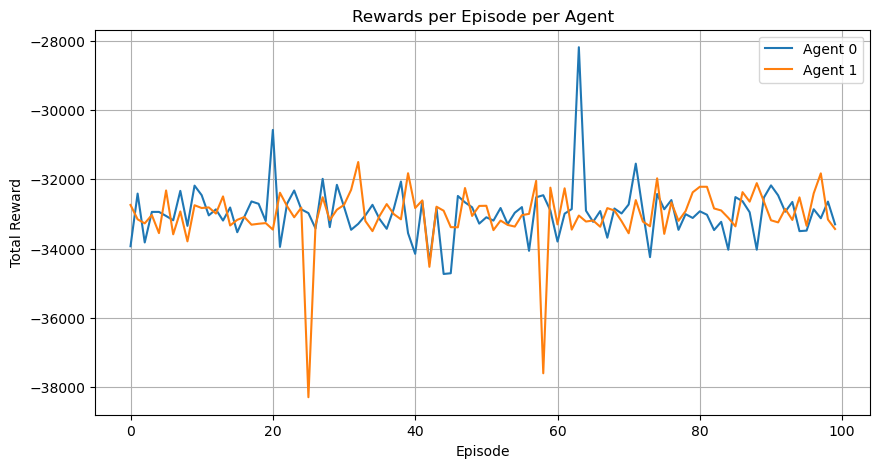

In [35]:
import matplotlib.pyplot as plt

num_episodes = 100
num_agents = 2
agent_rewards = {agent_id: [] for agent_id in range(num_agents)}

for episode in range(num_episodes):
    raw_state = env.reset()
    state = {agent_id: torch.tensor([raw_state[agent_id]], dtype=torch.float32).to(device).clone() for agent_id in raw_state}

    total_rewards = {agent_id: 0 for agent_id in raw_state}
    done = False

    while not done:
        actions = {}
        log_probs = {}
        state_values = {}
        next_state_values = {}
        advantages = {}
        actor_losses = {}
        critic_losses = {}

        for agent_id, agent_state in state.items():
            prob_actions = actor(agent_state.clone())
            dist = torch.distributions.Categorical(prob_actions)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            actions[agent_id] = action.item()
            log_probs[agent_id] = log_prob

        next_state, reward, done, _, _ = env.step(actions)
        next_state = {agent_id: torch.tensor([next_state[agent_id]], dtype=torch.float32).to(device).clone() for agent_id in next_state}

        for agent_id in state.keys():
            total_rewards[agent_id] += reward[agent_id]

        state = next_state

    for agent_id in total_rewards:
        agent_rewards[agent_id].append(total_rewards[agent_id])

    print(f"Episode {episode + 1} completed. Rewards: {total_rewards}")

#plot
plt.figure(figsize=(10, 5))
for agent_id, rewards in agent_rewards.items():
    plt.plot(rewards, label=f'Agent {agent_id}')

plt.title('Rewards per Episode per Agent')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

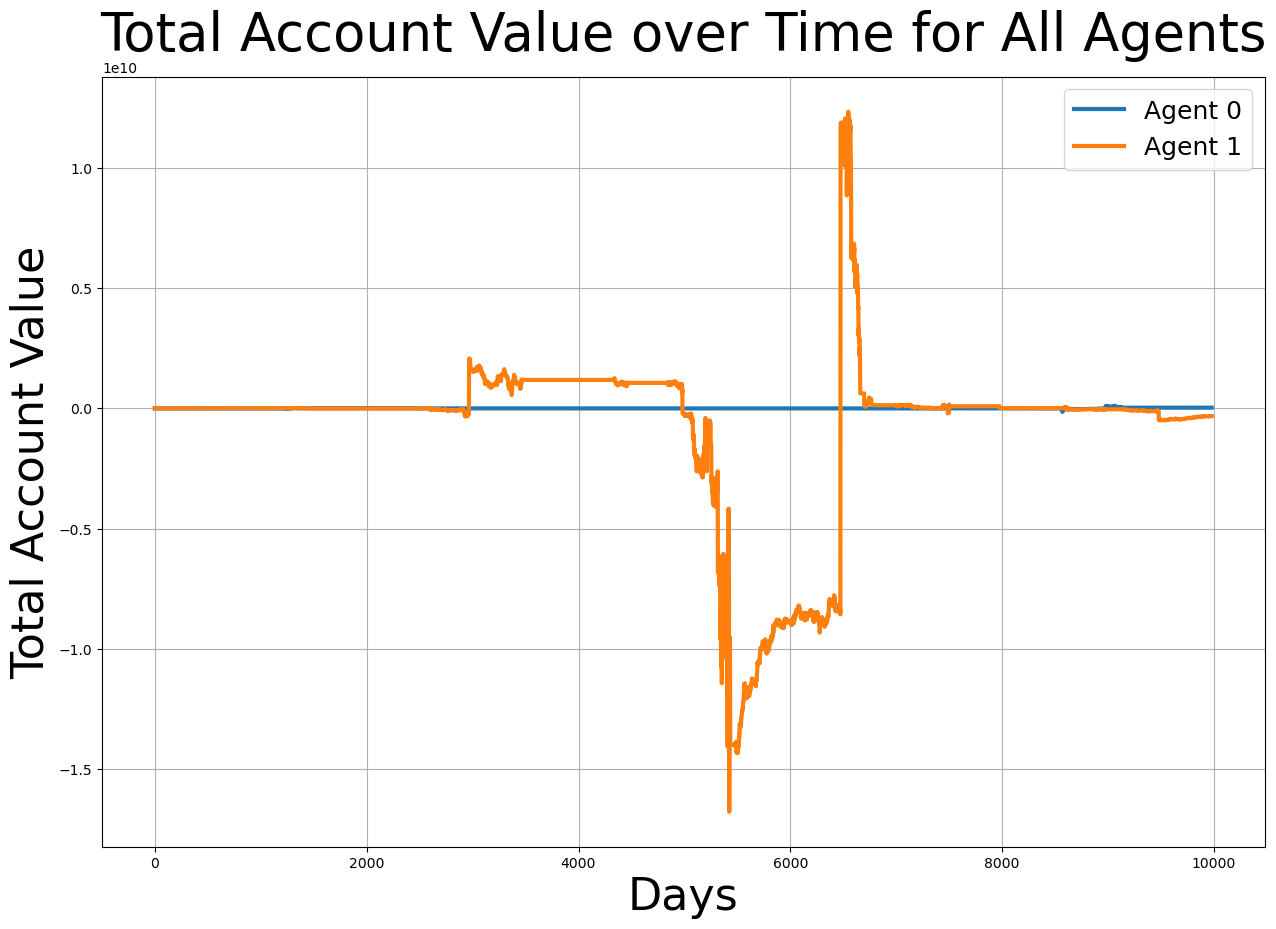

In [36]:
env.render()

In [37]:
import pickle

save_dir = "model_saves"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#save the model state:
torch.save(actor.state_dict(), os.path.join(save_dir, 'A2C_25_actor_model.pth'))
torch.save(critic.state_dict(), os.path.join(save_dir, 'A2C_25_critic_model.pth'))
print("Model state dictionaries saved.")

#save the rewards data
rewards_file = os.path.join(save_dir, 'A2C_25_agent_rewards.pkl')
with open(rewards_file, 'wb') as f:
    pickle.dump(agent_rewards, f)
print(f"Rewards data saved to {rewards_file}.")

Model state dictionaries saved.
Rewards data saved to model_saves\A2C_1_agent_rewards.pkl.


Reset states: {0: 0, 1: 0}
Test Episode 1 completed. Rewards: {0: -8278.052140747859, 1: -8180.63682637106}
Reset states: {0: 0, 1: 0}
Test Episode 2 completed. Rewards: {0: -8028.981371373676, 1: -8000.652653029843}
Reset states: {0: 0, 1: 0}
Test Episode 3 completed. Rewards: {0: -8098.07852898723, 1: -7785.541786113522}
Reset states: {0: 0, 1: 0}
Test Episode 4 completed. Rewards: {0: -7890.67150643859, 1: -7843.80200489263}
Reset states: {0: 0, 1: 0}
Test Episode 5 completed. Rewards: {0: -7968.778708333067, 1: -7639.975398775256}
Reset states: {0: 0, 1: 0}
Test Episode 6 completed. Rewards: {0: -8010.260648676782, 1: -7799.116512777237}
Reset states: {0: 0, 1: 0}
Test Episode 7 completed. Rewards: {0: -8012.686968888392, 1: -8175.980772981534}
Reset states: {0: 0, 1: 0}
Test Episode 8 completed. Rewards: {0: -7813.928868919675, 1: -8171.634229910176}
Reset states: {0: 0, 1: 0}
Test Episode 9 completed. Rewards: {0: -8167.76134642765, 1: -8298.289258243689}
Reset states: {0: 0, 1: 

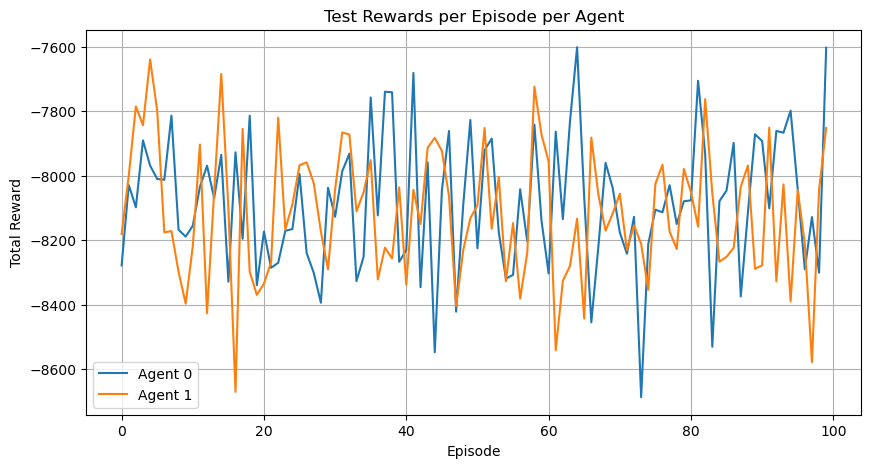

In [39]:
#setting the environment to test mode
test_env = StockEnvironment('data/', num_agents=2, train=False)

test_rewards = {agent_id: [] for agent_id in range(num_agents)}
num_test_episodes = 100
for episode in range(num_test_episodes):
    raw_state = test_env.reset()
    state = {agent_id: torch.tensor([raw_state[agent_id]], dtype=torch.float32).to(device).clone() for agent_id in raw_state}

    total_rewards = {agent_id: 0 for agent_id in raw_state}
    done = False

    while not done:
        actions = {}

        for agent_id, agent_state in state.items():
            prob_actions = actor(agent_state.clone())
            dist = torch.distributions.Categorical(prob_actions)
            action = dist.sample()

            actions[agent_id] = action.item()

        next_state, reward, done, _, _ = test_env.step(actions)
        next_state = {agent_id: torch.tensor([next_state[agent_id]], dtype=torch.float32).to(device).clone() for agent_id in next_state}

        for agent_id in state.keys():
            total_rewards[agent_id] += reward[agent_id]

        state = next_state

    for agent_id in total_rewards:
        test_rewards[agent_id].append(total_rewards[agent_id])

    print(f"Test Episode {episode + 1} completed. Rewards: {total_rewards}")

#Plot
plt.figure(figsize=(10, 5))
for agent_id, rewards in test_rewards.items():
    plt.plot(rewards, label=f'Agent {agent_id}')
plt.title('Test Rewards per Episode per Agent')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

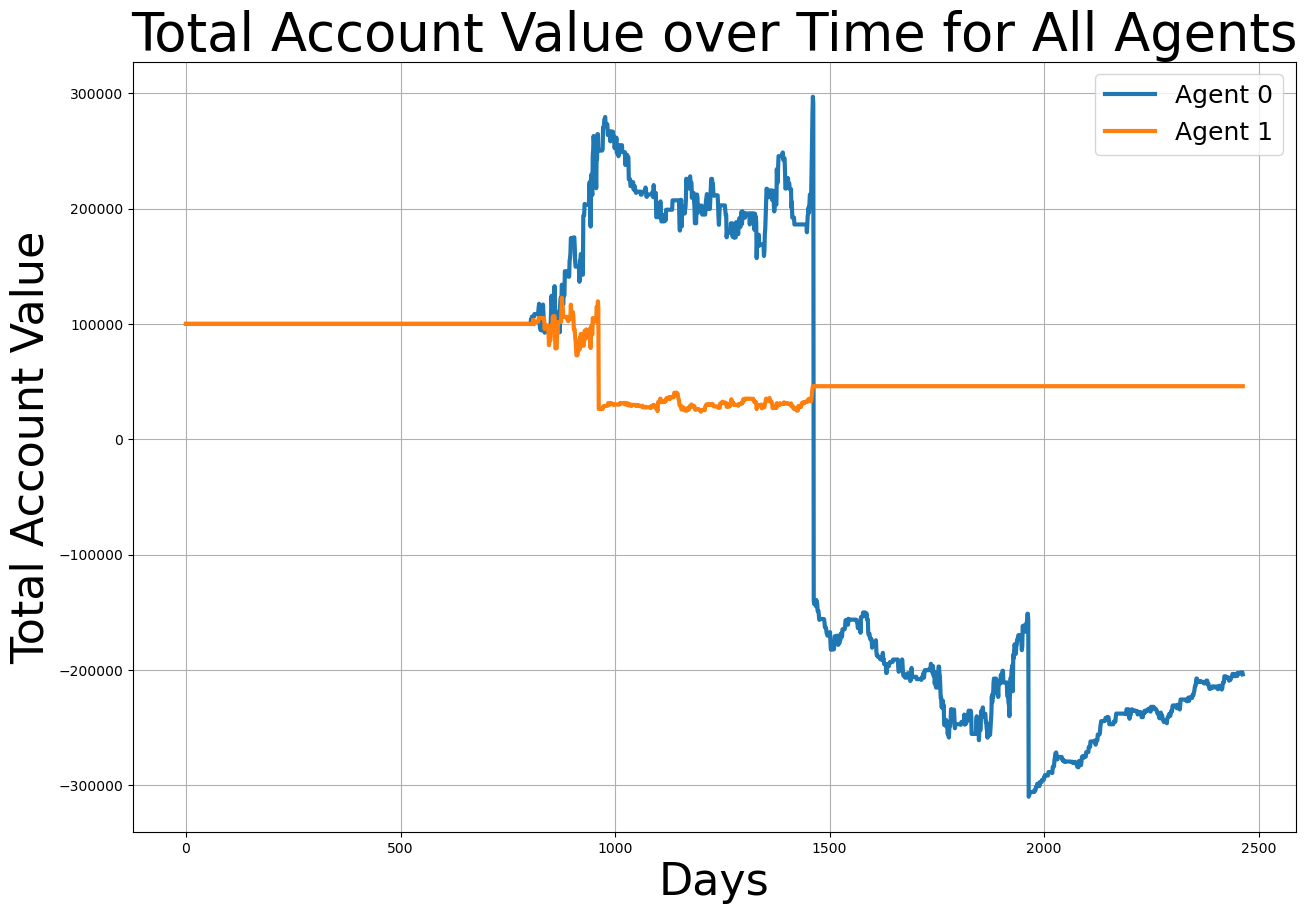

In [41]:
test_env.render()